In [10]:
"""
🔮 Prever a posição da ZCIT para os próximos 5 dias!
Obs: Referente a data de hoje.
"""
from loczcit_iqr.core.data_loader_ecmwf_forecast import ECMWFForecastLoader
from loczcit_iqr.core.processor import DataProcessor
from loczcit_iqr.core.iqr_detector import IQRDetector
from loczcit_iqr.core.spline_interpolator import (
    SplineInterpolator, 
    SplineParameters, 
    InterpolationMethod
)
from loczcit_iqr.plotting.visualizer import ZCITVisualizer

import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [11]:
# =============================================================================
# 1. CARREGAR PREVISÃO
# =============================================================================
print("📡 Baixando previsão de OLR do ECMWF IFS...")
# Criar loader
loader = ECMWFForecastLoader()

# Especificar rodada das 12Z de hoje (00Z e 12Z)
run_time = datetime(2026, 2, 8, 0, 0)  # 26/12/2025 12:00 UTC

# Carregar previsão usando rodada específica
forecast = loader.load_forecast(
    forecast_days=5,
    run_time=run_time
)

# Extrair metadados da previsão
forecast_run = forecast.attrs.get('forecast_run', 'N/A')
forecast_days = forecast.attrs.get('forecast_days', 5)

# Converter string ISO para datetime
if isinstance(forecast_run, str) and forecast_run != 'N/A':
    run_datetime = datetime.fromisoformat(forecast_run)
    run_str = run_datetime.strftime('%d/%m/%Y %H')
    
    # Calcular período de validade
    valid_start = run_datetime + timedelta(days=1)
    valid_end = run_datetime + timedelta(days=forecast_days)
    period_str = f"{valid_start.strftime('%d/%m')} - {valid_end.strftime('%d/%m/%Y')}"
else:
    run_str = "N/A"
    period_str = "N/A"

print(f"   ✅ Rodada: {run_str}Z")
print(f"   ✅ Período: {period_str}")


📡 Baixando previsão de OLR do ECMWF IFS...
2026-02-08 12:13:13,147 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO - ECMWFForecastLoader inicializado (source: aws)
2026-02-08 12:13:13,150 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO - Carregando previsão de OLR para 5 dias
2026-02-08 12:13:13,150 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO - Calculando OLR dia 1: steps 0h -> 24h
2026-02-08 12:13:13,189 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO -   Dia 1: OLR médio = 262.22 W/m²
2026-02-08 12:13:13,189 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO - Calculando OLR dia 2: steps 24h -> 48h
2026-02-08 12:13:13,241 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO -   Dia 2: OLR médio = 264.09 W/m²
2026-02-08 12:13:13,242 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO - Calculando OLR dia 3: steps 48h -> 72h
2026-02-08 12:13:13,292 - loczcit_iqr.core.data_loader_ecmwf_forecast - INFO -   Dia 3: OLR médio = 262.94 W/m²
2026-02-08 12:13:13,293 

In [5]:
print(forecast)

<xarray.Dataset> Size: 161kB
Dimensions:  (lat: 117, lon: 337)
Coordinates:
  * lat      (lat) float64 936B 17.0 16.75 16.5 16.25 ... -11.5 -11.75 -12.0
  * lon      (lon) float64 3kB -80.0 -79.75 -79.5 -79.25 ... 3.25 3.5 3.75 4.0
Data variables:
    olr      (lat, lon) float32 158kB 292.5 292.8 293.0 ... 284.5 284.2 283.5
Attributes:
    title:               ECMWF IFS OLR Forecast (mean) - NOAA-compatible
    institution:         European Centre for Medium-Range Weather Forecasts (...
    source:              ECMWF IFS Operational Forecast
    forecast_run:        2026-02-08T00:00:00
    forecast_days:       5
    aggregation_method:  mean
    history:             Created on 2026-02-08 11:15:45
    conventions:         CF-1.7
    spatial_resolution:  0.25 degrees
    converted_for:       loczcit_iqr library compatibility


In [6]:
# =============================================================================
# 2. PROCESSAR DADOS
# =============================================================================
print("\n🔍 Processando dados...")

# Identificar mínimos de OLR
processor = DataProcessor()
min_coords = processor.find_minimum_coordinates(
    forecast.olr, 
    method='column_minimum'
)
print(f"   ✅ Mínimos encontrados: {len(min_coords)}")

# Detectar outliers
detector = IQRDetector(constant=1.5)
coords_valid, coords_outliers, stats = detector.detect_outliers(min_coords)
print(f"   ✅ Coordenadas válidas: {len(coords_valid)}")
print(f"   ✅ Outliers removidos: {len(coords_outliers)}")

# Interpolar linha da ZCIT
interpolator = SplineInterpolator()
params = SplineParameters(
    method=InterpolationMethod.BSPLINE, 
    smooth_factor='high'
)
zcit_line, interp_stats = interpolator.interpolate(coords_valid, parameters=params)


🔍 Processando dados...
2026-02-08 11:16:13,952 - loczcit_iqr.core.processor - INFO - Arquivo padrão da área de estudo encontrado: E:\ambiente_python_2025-main\src\data\shapefiles\Area_LOCZCIT.parquet
2026-02-08 11:16:13,953 - loczcit_iqr.core.processor - INFO - Buscando mínimos de OLR (método: column_minimum, threshold: None, raio: 1px)
2026-02-08 11:16:13,953 - loczcit_iqr.core.processor - INFO - Carregando área de estudo de: E:\ambiente_python_2025-main\src\data\shapefiles\Area_LOCZCIT.parquet
2026-02-08 11:16:14,736 - loczcit_iqr.core.processor - INFO - Encontradas 37 coordenadas de mínimo
   ✅ Mínimos encontrados: 37
2026-02-08 11:16:14,737 - loczcit_iqr.core.iqr_detector - INFO - IQRDetector inicializado com constante: 1.5
2026-02-08 11:16:14,738 - loczcit_iqr.core.iqr_detector - INFO - Detectando outliers em 37 coordenadas (analisando latitude)
2026-02-08 11:16:14,739 - loczcit_iqr.core.iqr_detector - INFO - Detecção concluída: 29 válidas, 8 outliers
   ✅ Coordenadas válidas: 29

In [7]:
# =============================================================================
# 3. CALCULAR ESTATÍSTICAS DA ZCIT
# =============================================================================
# Latitude média da ZCIT prevista

# Extrair coordenadas do LineString
if hasattr(zcit_line, 'coords'):
    # É um objeto Shapely LineString
    coords_list = list(zcit_line.coords)
    lats_zcit = [coord[1] for coord in coords_list]
else:
    # É uma lista de tuplas
    lats_zcit = [coord[1] for coord in zcit_line]

lat_media = sum(lats_zcit) / len(lats_zcit)
lat_min = min(lats_zcit)
lat_max = max(lats_zcit)

# OLR médio
olr_medio = float(forecast.olr.mean())

print(f"\n📊 Estatísticas da ZCIT Prevista:")
print(f"   📍 Latitude média: {lat_media:.2f}°")
print(f"   📍 Variação: {lat_min:.2f}° a {lat_max:.2f}°")
print(f"   🌡️  OLR médio: {olr_medio:.1f} W/m²")


📊 Estatísticas da ZCIT Prevista:
   📍 Latitude média: 2.09°
   📍 Variação: 0.60° a 4.15°
   🌡️  OLR médio: 263.4 W/m²



🗺️  Gerando visualização...

Iniciando a criação da visualização completa...
✅ Visualização completa pronta.


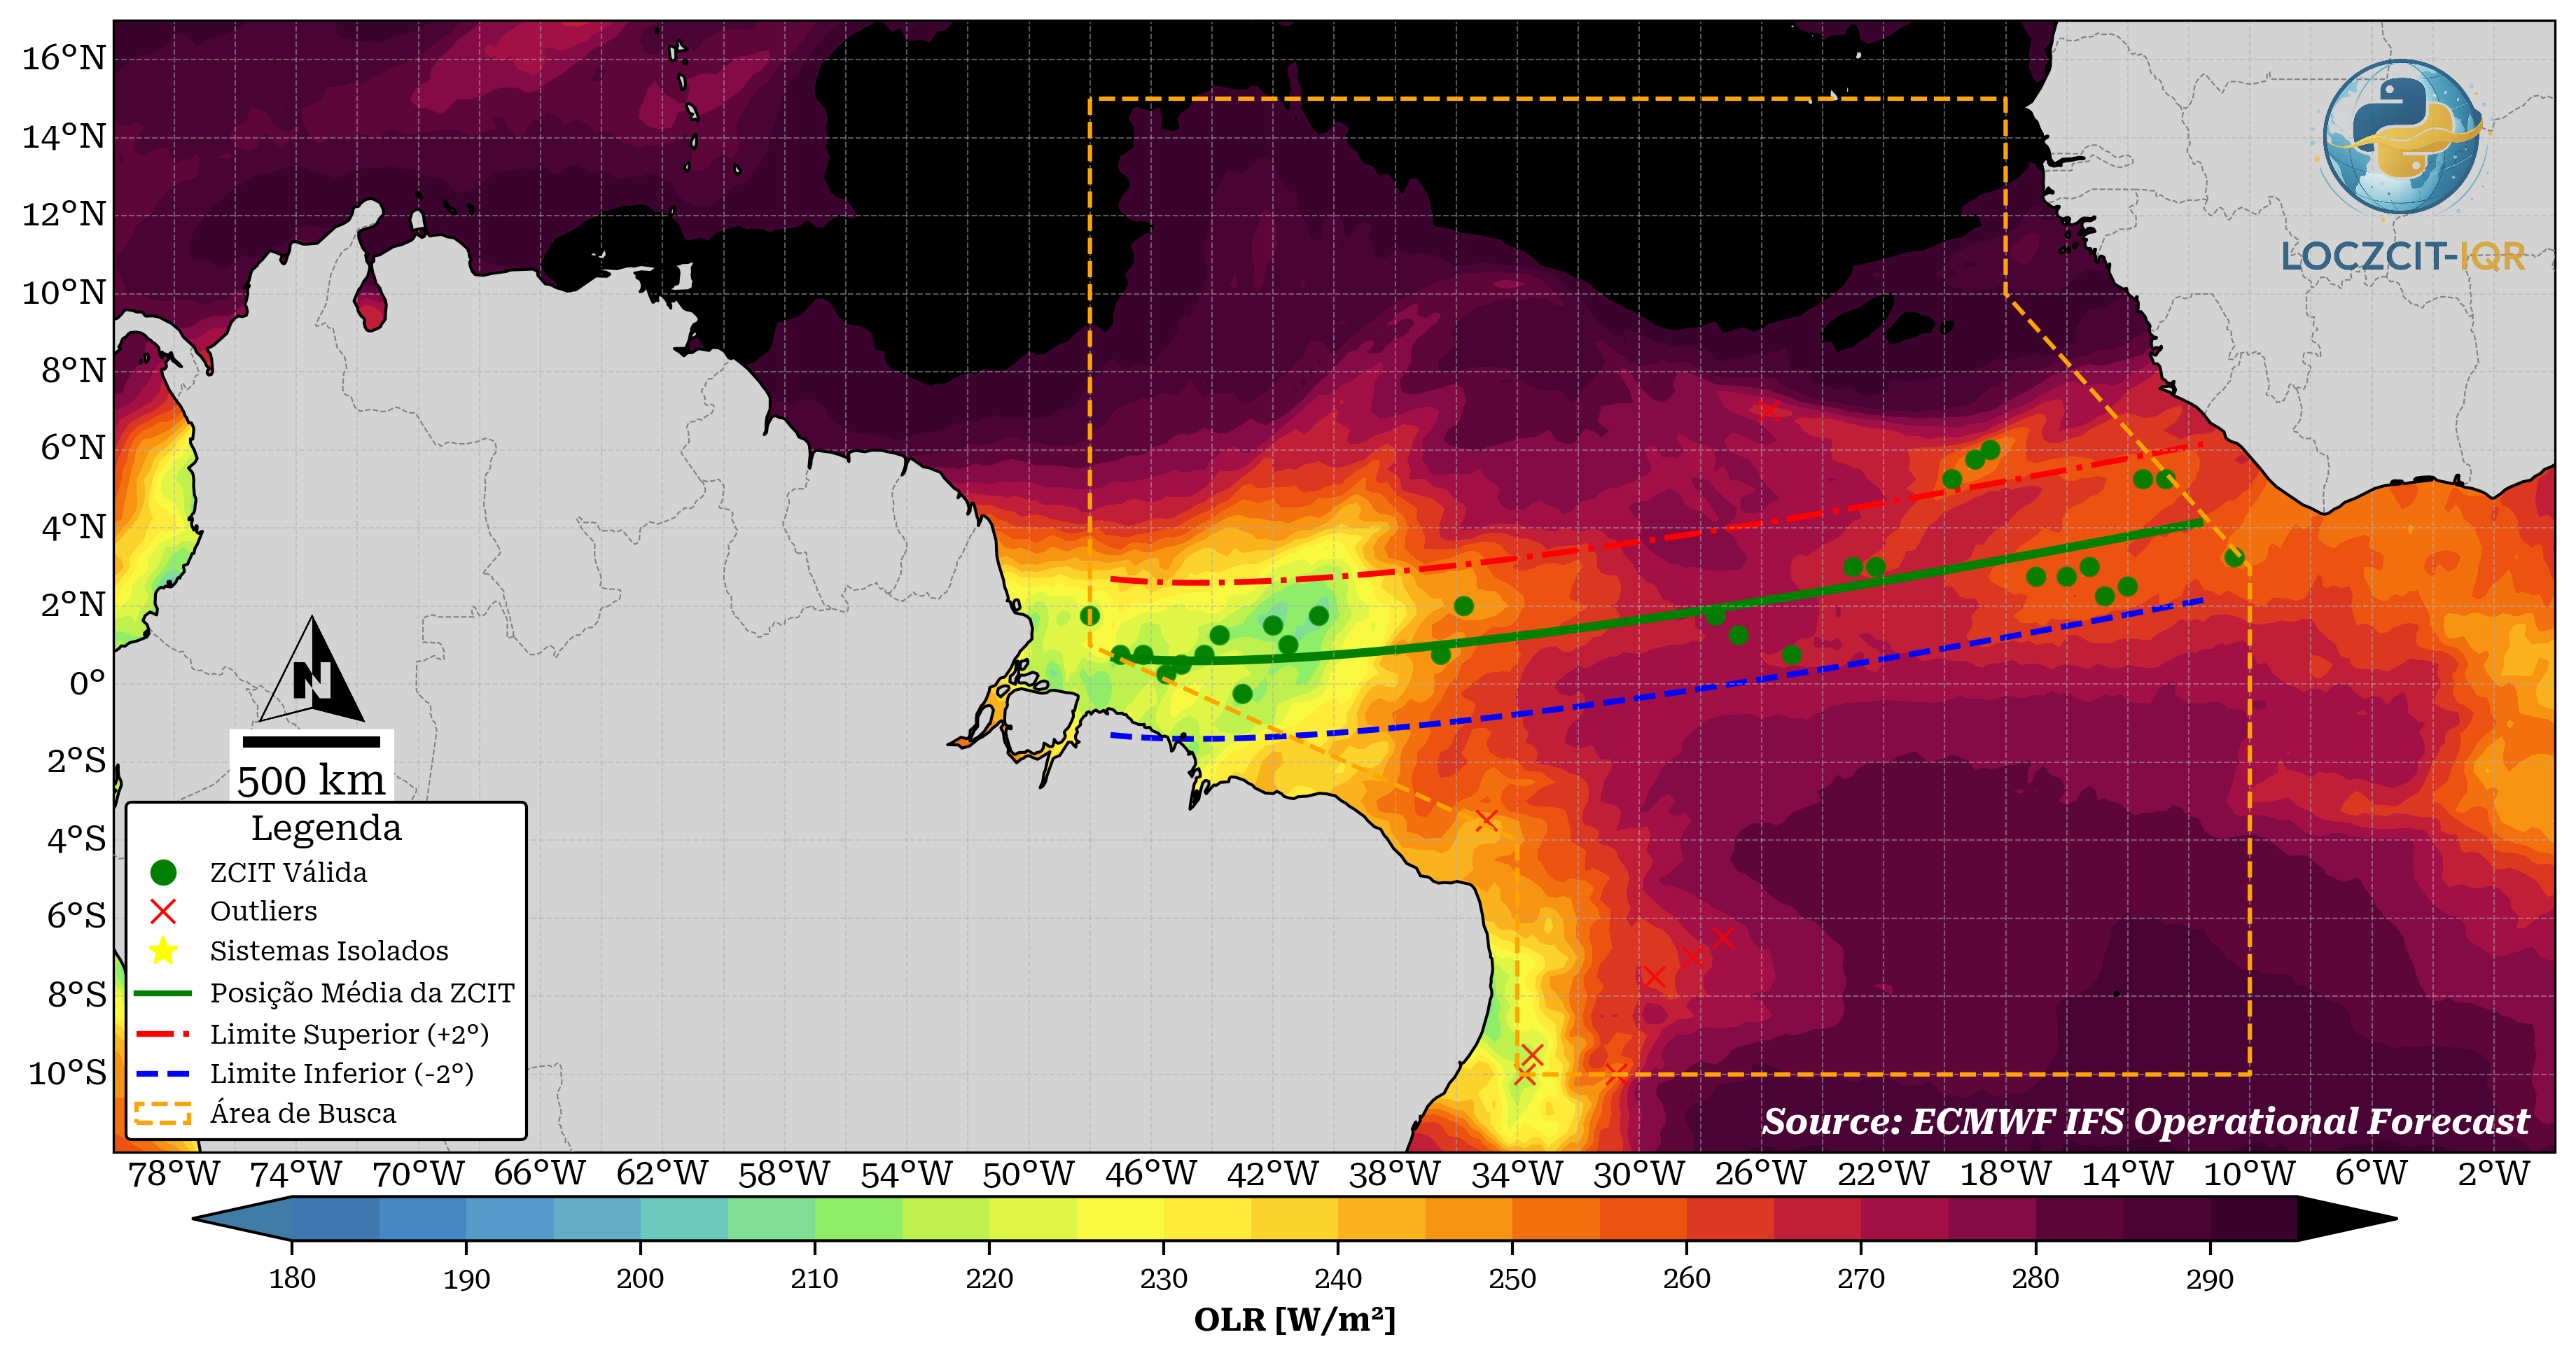

In [8]:
# =============================================================================
# 4. VISUALIZAÇÃO COM TÍTULO INFORMATIVO
# =============================================================================
print("\n🗺️  Gerando visualização...")

viz = ZCITVisualizer(template='publication')

fig, ax = viz.plot_complete_analysis(
    olr_data=forecast,
    title="",  # Vamos criar título customizado
    coords_valid=coords_valid,
    coords_outliers=coords_outliers,
    zcit_line=zcit_line,
    study_area_visible=True,
    credits="ECMWF"
)



🗺️  Gerando visualização...

Iniciando a criação da visualização completa...
✅ Visualização completa pronta.

💾 Figura salva: previsao_zcit_20260208_00Z.png


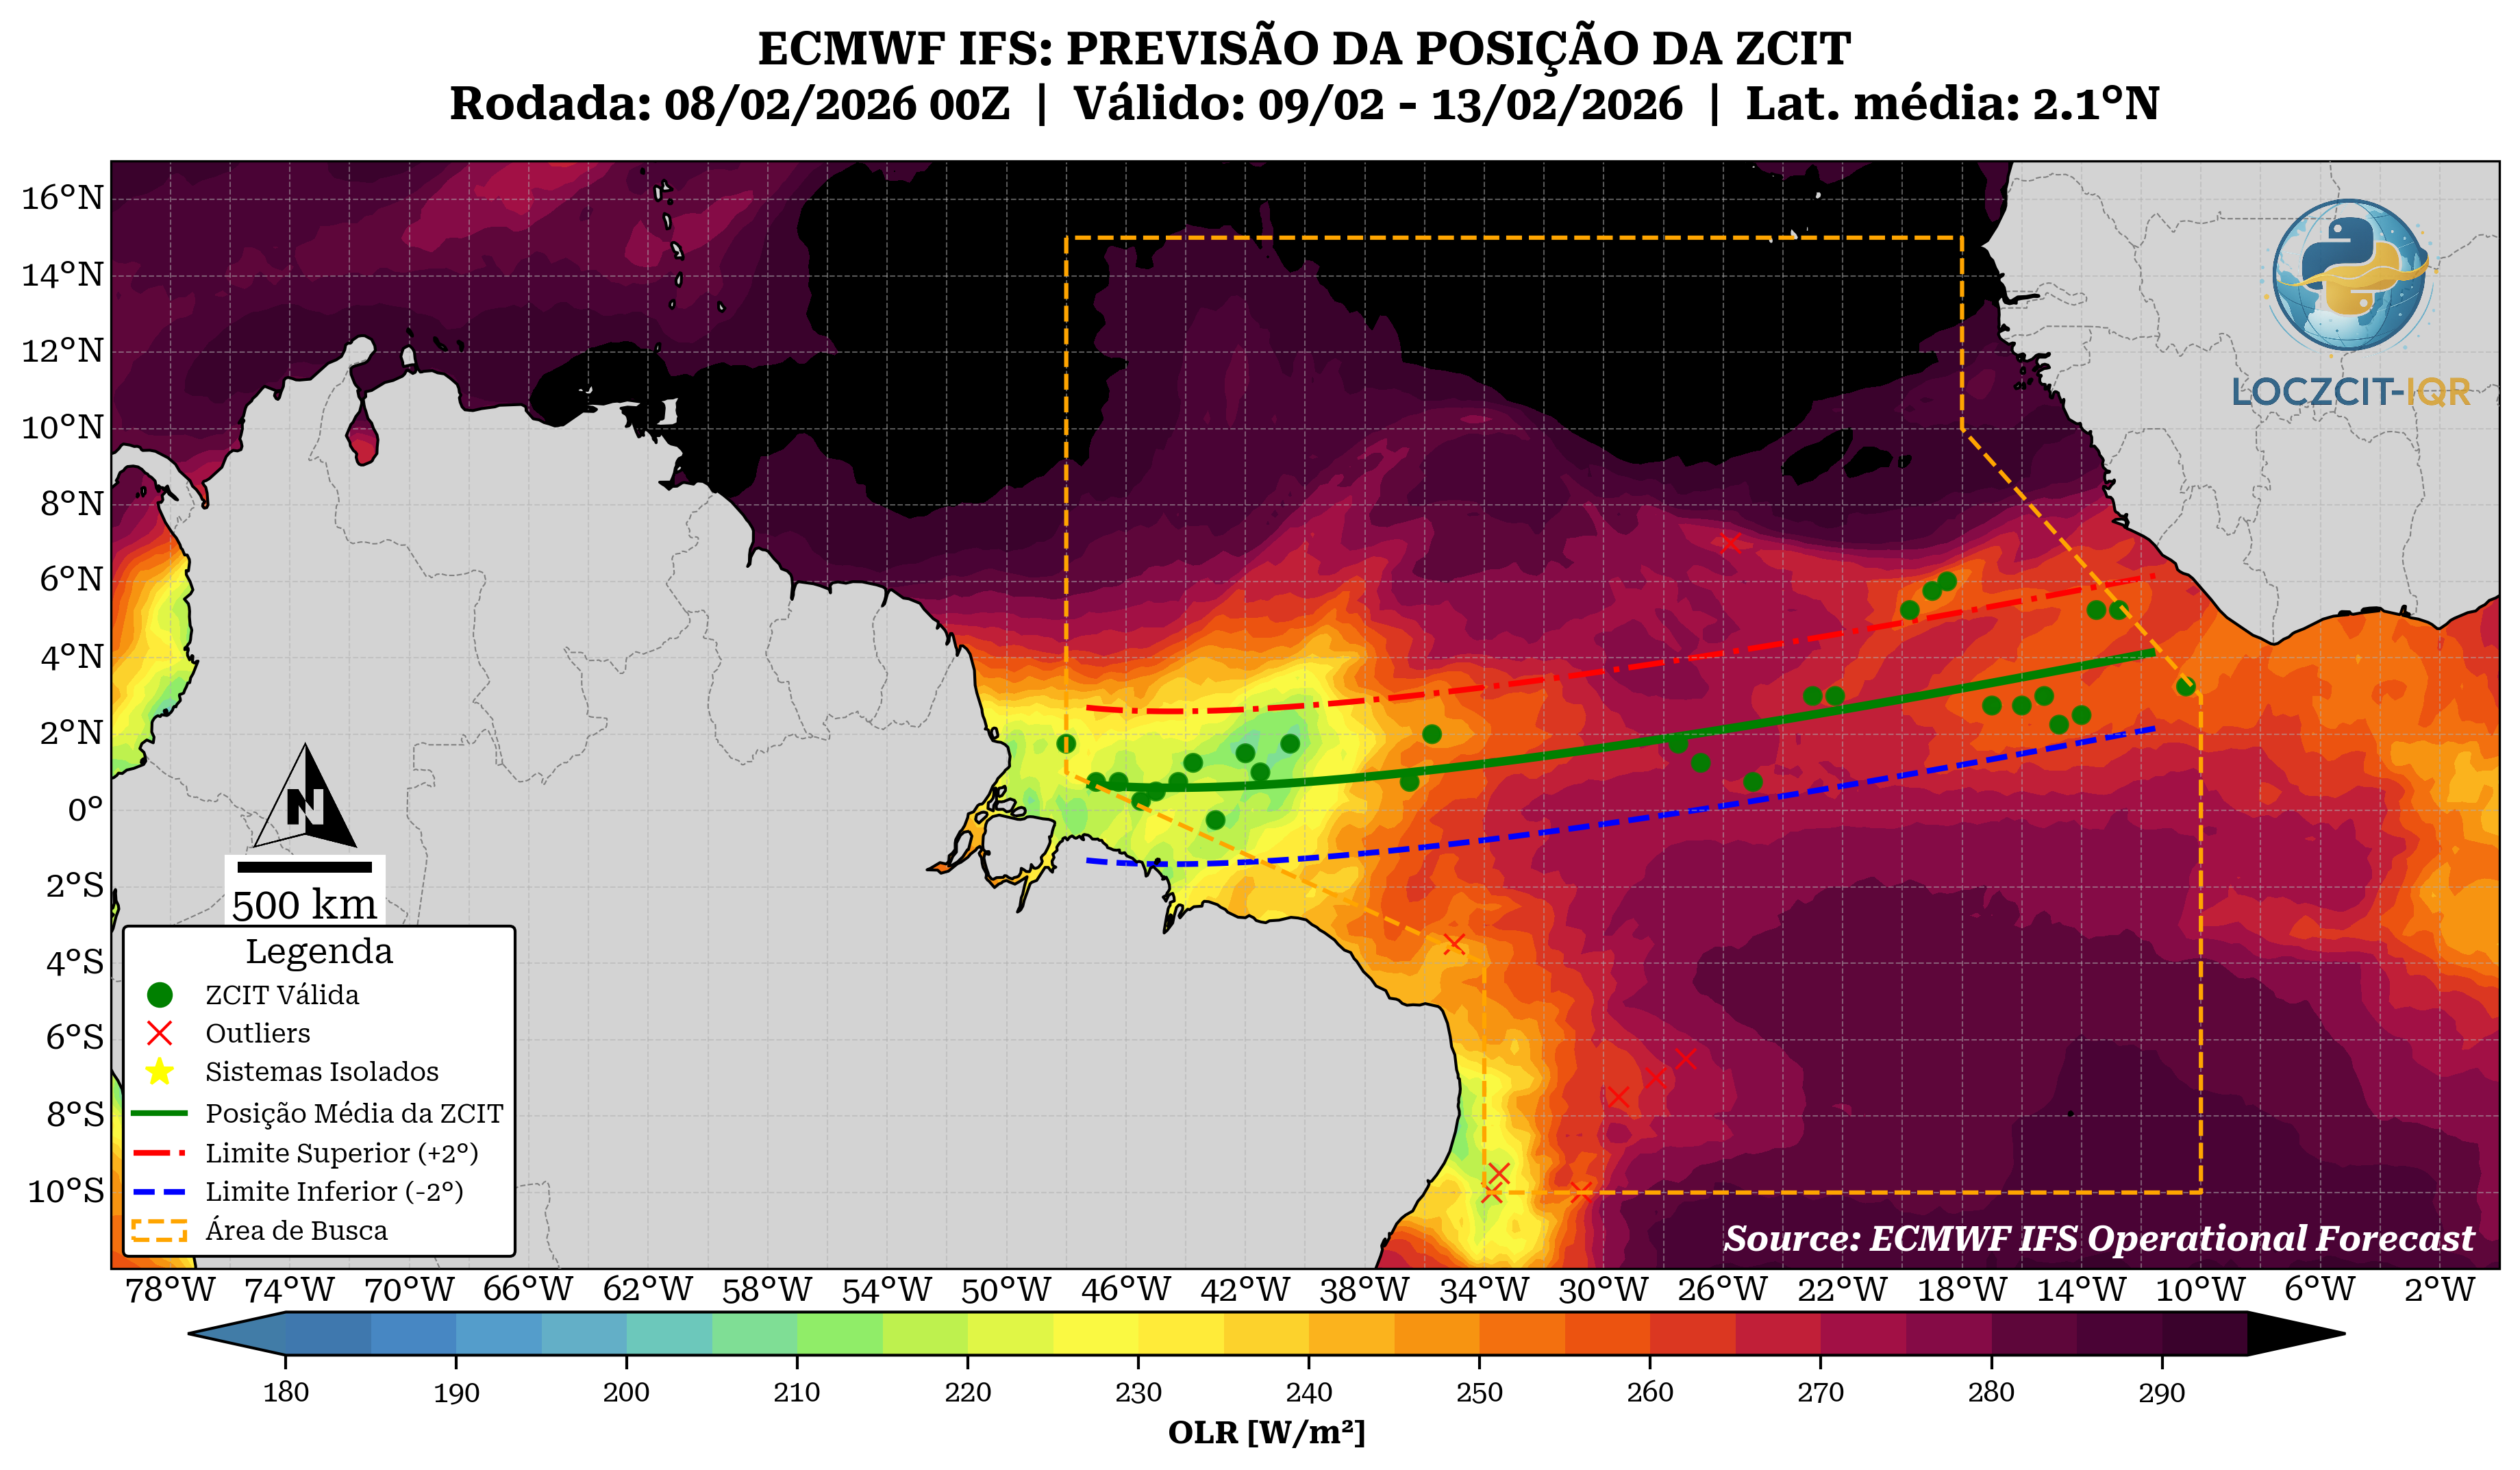


📋 RESUMO DA PREVISÃO
   🕐 Rodada ECMWF:      08/02/2026 00Z
   📅 Período válido:    09/02 - 13/02/2026
   📍 Lat. média ZCIT:  2.09°N
   📏 Amplitude Lat.:    3.55°
   🌡️  OLR médio:         263.4 W/m²
   ✅ Pontos válidos:    29
   ❌ Outliers:          8


In [9]:
# =============================================================================
# 4. VISUALIZAÇÃO COM TÍTULO INFORMATIVO
# =============================================================================
print("\n🗺️  Gerando visualização...")

# -----------------------------------------------------------------------------
# TÍTULO INFORMATIVO CUSTOMIZADO
# -----------------------------------------------------------------------------
titulo_principal = f"ECMWF IFS: PREVISÃO DA POSIÇÃO DA ZCIT\nRodada: {run_str}Z  |  Válido: {period_str}  |  Lat. média: {lat_media:.1f}°N"

viz = ZCITVisualizer(template='publication')

# Gerar o gráfico base
fig, ax = viz.plot_complete_analysis(
    olr_data=forecast,
    title=titulo_principal,
    coords_valid=coords_valid,
    coords_outliers=coords_outliers,
    zcit_line=zcit_line,
    study_area_visible=True,
    credits="ECMWF"
)


# -----------------------------------------------------------------------------
# ANOTAÇÃO COM RESUMO (Correção do KeyError aqui)
# -----------------------------------------------------------------------------
resumo_texto = (
    f"IQR: {stats['lower_limit']:.1f}° – {stats['upper_limit']:.1f}°\n"
    f"Pontos: {len(coords_valid)} válidos, {len(coords_outliers)} outliers\n"
    f"OLR médio: {olr_medio:.0f} W/m²"
)

# =============================================================================
# 5. SALVAR E MOSTRAR
# =============================================================================
# Nome do arquivo dinâmico baseado na rodada
if isinstance(forecast_run, str) and forecast_run != 'N/A':
    filename = f"previsao_zcit_{run_datetime.strftime('%Y%m%d_%H')}Z.png"
else:
    filename = f"previsao_zcit_{datetime.now().strftime('%Y%m%d_%H%M')}.png"

# Salvar em alta resolução
plt.savefig(filename, dpi=200, bbox_inches='tight', facecolor='white')
print(f"\n💾 Figura salva: {filename}")

# Exibir gráfico
plt.show()

# =============================================================================
# 6. RESUMO FINAL NO CONSOLE
# =============================================================================
print("\n" + "=" * 60)
print("📋 RESUMO DA PREVISÃO")
print("=" * 60)
print(f"   🕐 Rodada ECMWF:      {run_str}Z")
print(f"   📅 Período válido:    {period_str}")
print(f"   📍 Lat. média ZCIT:  {lat_media:.2f}°N")
print(f"   📏 Amplitude Lat.:    {lat_max - lat_min:.2f}°")
print(f"   🌡️  OLR médio:         {olr_medio:.1f} W/m²")
print(f"   ✅ Pontos válidos:    {len(coords_valid)}")
print(f"   ❌ Outliers:          {len(coords_outliers)}")
print("=" * 60)